In [1]:
import torch as t
import torch.nn as nn
from torchsummary import summary
import matplotlib.pylab as plt

## 1. torch.Tensor.register_hook(hook)

### 1.1 获得非叶子节点的grad

In [ ]:
# pytorch中非叶子节点的梯度在一次计算之后，不会保留其梯度信息
# 但是可以使用钩子函数对其所在的非叶子节点进行挂钩保留数据
def grad_hook(grad):
    y_grad.append(grad)

In [ ]:
y_grad = list()
x = t.tensor([[1., 2.], [3., 4.]], requires_grad=True)

In [ ]:
x

In [ ]:
y = x + 1
y

In [ ]:
# 注册 钩子函数
h = y.register_hook(grad_hook)

In [ ]:
z= t.mean(y**2)
z.backward()

In [ ]:
z

In [ ]:
# y的类型
type(y)

In [ ]:
# 是否为叶子节点
y.is_leaf

In [ ]:
x.is_leaf

In [ ]:
# 输出网路中y的梯度
print(y_grad)

In [ ]:
# 去除hook
h.remove()

### 1.2 修改非叶子节点的梯度

In [14]:
def grad_hook(grad):
    grad *= 2

In [15]:
x = t.tensor([2., 2., 2., 2.], requires_grad=True)
y = t.pow(x, 2)
z = t.mean(y)

In [16]:
z

tensor(4., grad_fn=<MeanBackward0>)

In [17]:
h = x.register_hook(grad_hook)
z.backward()

In [18]:
x.grad

tensor([2., 2., 2., 2.])

In [19]:
h.remove()

**结论：**原x的梯度为tensor([1., 1., 1., 1.])，经grad_hook操作后，梯度为tensor([2., 2., 2., 2.])。

## 2. torch.nn.Module.register_forward_hook

In [20]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 2, 3)
        self.pool1 = nn.MaxPool2d(2, 2)
    def forward(self, x):
        x = self.conv1(x)
        x = self.pool1(x)
        return x

In [21]:
Net()

Net(
  (conv1): Conv2d(1, 2, kernel_size=(3, 3), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)

In [22]:
summary(Net(), input_size=(1, 4, 4), device="cpu", batch_size=1)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1               [1, 2, 2, 2]              20
         MaxPool2d-2               [1, 2, 1, 1]               0
Total params: 20
Trainable params: 20
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------


In [23]:
def forward_hook(module, data_input, data_output):
    fmap_block.append(data_output)
    input_block.append(data_input)

In [24]:
net = Net()

# 初始化网络
net.conv1.weight[0].fill_(1)
net.conv1.weight[1].fill_(2)
net.conv1.bias.data.zero_()

tensor([0., 0.])

In [25]:
# 注册hook
fmap_block = list()
input_block = list()
# 注册卷积层
net.conv1.register_forward_hook(forward_hook)

In [26]:
# 输入image
fake_img = t.rand(1, 1, 4, 4)
output = net(fake_img)
output

tensor([[[[4.8379]],

         [[9.6757]]]], grad_fn=<MaxPool2DWithIndicesBackward>)

In [27]:
# 输出钩子中的数据
print("特征图：")
fmap_block[0]

特征图：


tensor([[[[2.9796, 4.1535],
          [3.6634, 4.8379]],

         [[5.9592, 8.3069],
          [7.3267, 9.6757]]]], grad_fn=<MkldnnConvolutionBackward>)

In [28]:
print("输入数据：")
# 输入位元组类型
input_block[0]

输入数据：


(tensor([[[[0.4901, 0.3729, 0.1424, 0.6849],
           [0.3202, 0.7771, 0.1436, 0.9103],
           [0.0035, 0.4127, 0.3172, 0.3925],
           [0.7292, 0.4921, 0.4678, 0.9247]]]]),)

In [29]:
input_block[0][0].shape

torch.Size([1, 1, 4, 4])

## 3. torch.nn.Module.register_forward_pre_hook

功能：执行forward()之前调用hook函数。 形式：hook(module, input) -> None 应用场景举例：暂时没碰到过，希望读者朋友补充register_forward_pre_hook相关应用场景。 register_forward_pre_hook与forward_hook一样，是在module.call中注册的，与forward_hook不同的是，其在module执行forward之前就运行了，具体可看module.call中的代码，第一行就是执行forward_pre_hook的相关操作

## 4.torch.nn.Module.register_backward_hook

## 实现Grad_CAM

In [30]:
import cv2
import os
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms

### lenet5网络

In [31]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool1(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [32]:
print(Net())

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


### 图片处理

In [33]:
def img_transforms(img_in, transforms):
    """img　图片转换"""
    img = img_in.copy()
    img = Image.fromarray(np.uint8(img))
    img= transforms(img)
    # (C, H, W)--->(B, C, H, W)
    img = img.unsqueeze(0)
    return img

### 图片读取 

In [34]:
def img_preprocess(img_in):
    """图像预处理"""
    img = img_in.copy()
    # TODO:是否可以修改transform形式
    img = cv2.resize(img, (32, 32))
    
    img = img[:, :, ::-1]   # BGR --> RGB
    transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.4948052, 0.48568845, 0.44682974], [0.24580306, 0.24236229, 0.2603115])
    ])
    img_input = img_transforms(img, transform)
    return img_input

### 挂载钩子函数

In [35]:
# 后向
def backward_hook(module, grad_in, grad_out):
    grad_block.append(grad_out[0].detach())

# 前向
def farward_hook(module, input, output):
    fmap_block.append(output)

### 显示cam

In [36]:
def show_cam_image(img, mask, out_dir, i):
    heatmap = cv2.applyColorMap(np.uint8(255*mask), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    cam = heatmap + np.float32(img)
    cam = cam / np.max(cam)

    path_cam_img = os.path.join(out_dir, "cam{}.jpg".format(i))
    path_raw_img = os.path.join(out_dir, "raw{}.jpg".format(i))
    if not os.path.exists(out_dir):
        os.makedirs(out_dir)
    cv2.imwrite(path_cam_img, np.uint8(255 * cam))
    cv2.imwrite(path_raw_img, np.uint8(255 * img))

### 计算类向量

In [37]:
def comp_class_vec(output_vec, index=None):
    """类别向量"""

    if not index:
        # 获得相应的类别索引
        index = np.argmax(output_vec.cpu().data.numpy())
    else:
        index = np.array(index)
        
    index = index[np.newaxis, np.newaxis]
    index = t.from_numpy(index)
    one_hot = t.zeros(1, 10).scatter_(1, index, 1)
    one_hot.requires_grad = True
    
    # 类别转为onehot向量
    class_vec = t.sum(one_hot*output)

    return class_vec

### 生成cam

In [133]:
def gen_cam(feature_map, grads):
    """
    依据梯度和特征图，生成cam
    :param feature_map: np.array， in [C, H, W]
    :param grads: np.array， in [C, H, W]
    :return: np.array, [H, W]
    """
    
    cam = np.zeros(feature_map.shape[1:], dtype=np.float32)
    weight = np.mean(grads, axis=(1, 2))
    
    for i, w in enumerate(weight):
        # 梯度权重乘以特征图
        cam += w * feature_map[i, :, :]
        
    # relu函数
    cam = np.maximum(cam, 0)
    # 还原原来的大小
    cam = cv2.resize(cam, (32, 32)) 
    # 归一化
    min_val = np.min(cam)
    max_val = np.max(cam)
#     cam -= np.min(cam)
#     cam /= np.max(cam)
    cam = (cam -min_val)/(max_val - min_val)
    
    return cam

In [134]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

### 读取图片，网路加载

In [135]:
i = 1

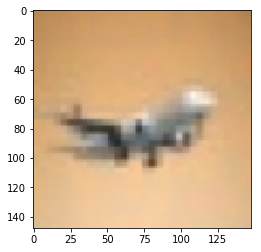

In [136]:
fmap_block = list()
grad_block = list()
img_path = "/home/gavin/Pytorch/PyTorch_Tutorial/Data/cam_img/test_img_1.png"
img = cv2.imread("/home/gavin/Pytorch/PyTorch_Tutorial/Data/cam_img/test_img_{}.png".format(i), 1)
plt.imshow(img)
plt.show()

In [137]:
# 加载数据
img_input = img_preprocess(img)
net = Net()
net.load_state_dict(t.load("./net_params_72p.pkl"))

<All keys matched successfully>

In [138]:
# 注册钩子
net.conv2.register_forward_hook(farward_hook)
net.conv2.register_backward_hook(backward_hook)

In [139]:
# shape 
output = net(img_input)
output.shape

torch.Size([1, 10])

In [140]:
output

tensor([[11.4452, -2.5265,  2.9020, -2.0100, -0.1641, -4.3873, -1.5677, -5.5348,
          2.6622, -0.8393]], grad_fn=<AddmmBackward>)

In [141]:
# 16张10*10的特征图
fmap_block[0][0].shape

torch.Size([16, 10, 10])

In [142]:
inx = output.cpu().argmax(1).data.numpy()
title = classes[inx[0]]
title

'plane'

In [143]:
# 反向传播， 计算梯度
net.zero_grad()
class_loss = comp_class_vec(output)

In [144]:
class_loss

tensor(11.4452, grad_fn=<SumBackward0>)

In [145]:
class_loss.backward()

In [146]:
# 得到图片像素的梯度
grad_block[0].shape

torch.Size([1, 16, 10, 10])

### 生成CAM

In [147]:
grad_val = grad_block[0].cpu().data.numpy().squeeze()

In [148]:
# 每一个特征图的权重
grad_val.shape

(16, 10, 10)

In [149]:
# 16张特征图
fmap = fmap_block[0].cpu().data.numpy().squeeze()
fmap.shape

(16, 10, 10)

In [150]:
cam = gen_cam(fmap, grad_val)

In [151]:
img_show = np.float32(cv2.resize(img, (32, 32)))/255
output_dir = "/home/gavin/Desktop/imgsss/"
show_cam_image(img_show, cam, output_dir, i=i)
i += 1

In [152]:
# heatmap = cv2.applyColorMap(np.uint8(255*cam), cv2.COLORMAP_JET)
# plt.imshow(heatmap)
# plt.show()

In [126]:
# heatmap = np.float32(heatmap) / 255
# cam = heatmap + np.float32(img_show)
# cam = cam / np.max(cam)
# plt.imshow(np.uint8(cam * 255))
# plt.xticks([])
# plt.yticks([])
# plt.title(title)
# plt.show()

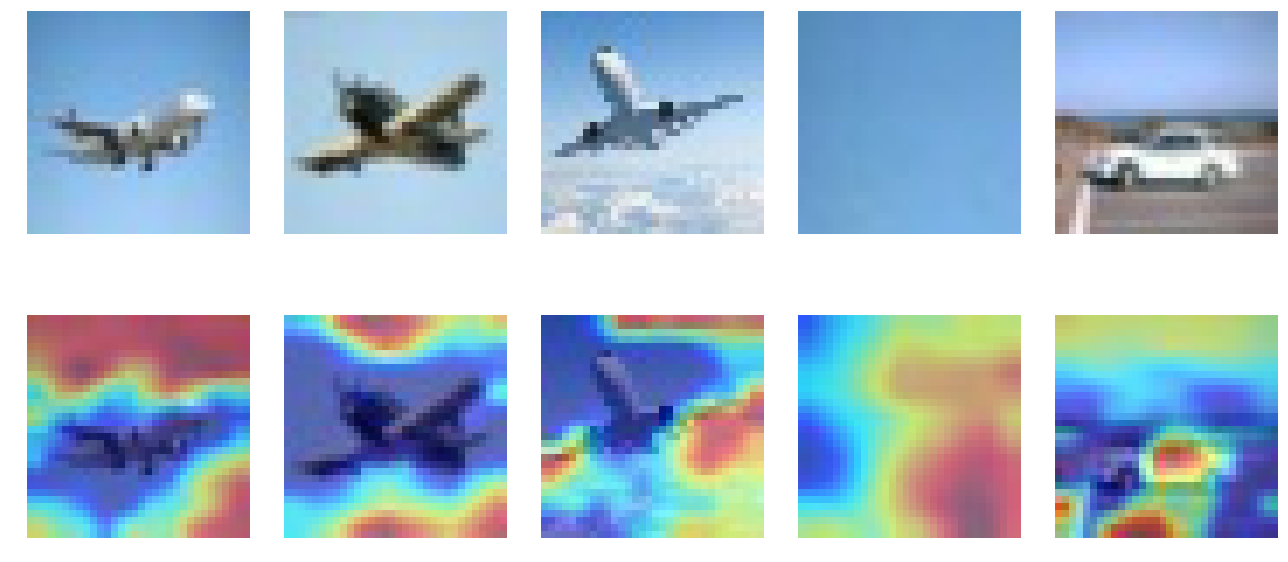

In [132]:
fig, axes = plt.subplots(2, 5, figsize=(18, 9))
for i in range(2):
        for j in range(5):
            if i == 0:
                axes[i][j].imshow(plt.imread("/home/gavin/Desktop/imgsss/raw{}.jpg".format(j+1), 1))
                axes[i][j].axis("off")
            else:
                axes[i][j].imshow(plt.imread("/home/gavin/Desktop/imgsss/cam{}.jpg".format(j+1), 1))
                axes[i][j].axis("off")
plt.xticks([])
fig.tight_layout()
plt.subplots_adjust()# 调整子图之间的距离
plt.savefig("./imgs/cam_alls.svg")
plt.show()

## 参考

[PyTorch的hook及其在Grad-CAM中的应用](https://zhuanlan.zhihu.com/p/75894080)  
[cv2.imread()和cv2.cvtColor() 的使用](https://blog.csdn.net/zhang_cherry/article/details/88951259)  
[cv2.imread()和matplotlib.image.imread()读取图片的一些区别,python](https://blog.csdn.net/qinglv1/article/details/80253581)  

### opencv BGR实例

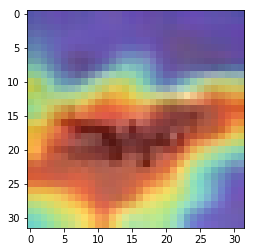

In [153]:
img = cv2.imread("/home/gavin/Desktop/imgsss/cam1.jpg")
plt.imshow(img)
plt.show()

### plt RGB实例

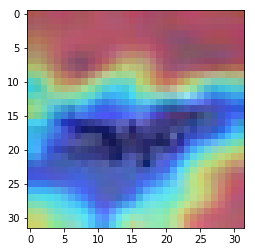

In [154]:
img = plt.imread("/home/gavin/Desktop/imgsss/cam1.jpg")
plt.imshow(img)
plt.show()